In [1]:
import numpy as np
import pandas as pd
import torch
from typing import Optional, Literal, Union
import matplotlib.pyplot as plt

# we use a local copy of the fast_soft_sort manually downloaded from
# https://github.com/google-research/fast-soft-sort/tree/master
from fast_soft_sort.pytorch_ops import soft_rank

## Test ordinary lr in torch

Data generating model and data:

In [2]:
def generate_data(n_features: int, n_samples: int, noise: float = 0.0) -> tuple[object, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """Generate data."""
    torch.manual_seed(0)

    # the true data generating model
    model_true = torch.nn.Linear(n_features, 1, bias=True)

    # For the simplicity of the analysis, set the model params
    # to the numbers running from 1 through (n_features + 1).
    with torch.no_grad():
        i = 1
        for name, param in model_true.named_parameters():
            param.copy_(torch.arange(i, i + param.numel()))
            i += param.numel()
            param.requires_grad = False

    # Generate training and test data.
    X_train = torch.rand((n_samples, n_features))
    y_train = model_true(X_train) + noise * torch.randn(size=(X_train.size()[0], 1))

    X_test = torch.rand((n_samples // 10, n_features))
    y_test = model_true(X_test) + noise * torch.randn(size=(X_test.size()[0], 1))

    return model_true, X_train, y_train, X_test, y_test

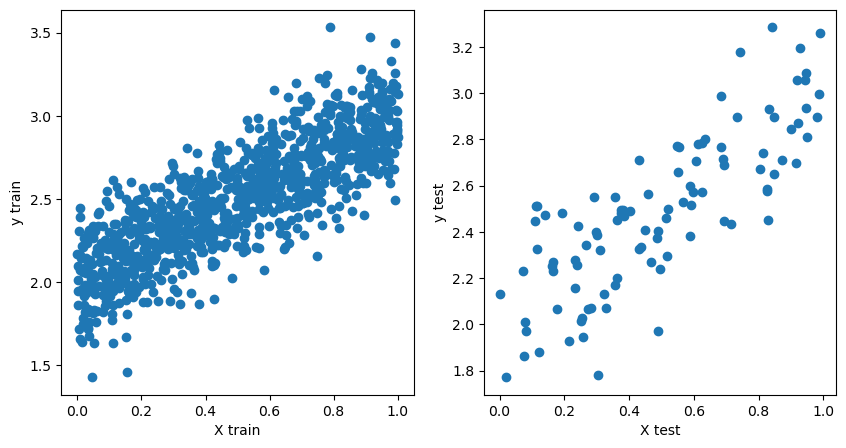

In [3]:
n_features = 1
n_samples = 1000
noise = 0.2

model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples, noise)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].scatter(X_train.detach().numpy(), y_train.numpy())
axs[0].set_xlabel("X train")
axs[0].set_ylabel("y train")

axs[1].scatter(X_test.detach().numpy(), y_test.numpy())
axs[1].set_xlabel("X test")
axs[1].set_ylabel("y test")

plt.show()

In [4]:
for name, param in model_true.named_parameters():
    print(name, param)

weight Parameter containing:
tensor([[1.]])
bias Parameter containing:
tensor([2.])


Help funcs:

In [79]:
def init_model(n_features: int, lr: float, weight_decay: float) -> tuple[object, object]:
    """Initialize model.
        Params:
            n_features: number of features the model will have
            lr: learning rate
            weight_decay: L2 regularization strength
        Return:
            initialized model and optimizer
    """
    torch.manual_seed(2023)
    model = torch.nn.Linear(n_features, 1, bias=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    return model, optimizer

def train_step(X: torch.Tensor, y: torch.Tensor, model: object, loss_fn: object, optimizer: object) -> torch.Tensor:
    """Make one training step."""
    # Compute prediction and loss
    y_hat = model(X)
    loss = loss_fn(y, y_hat)

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # did not forget!
    # print(model.weight.grad, model.bias.grad)

    return loss

def get_model_params(model):
    """Extract model params"""
    return torch.cat([param.data.squeeze().reshape(1, -1) for param in model.parameters()], dim=1)

def train(
        X_train: torch.Tensor,
        y_train: torch.Tensor,
        X_test: torch.Tensor,
        y_test: torch.Tensor,
        n_features: int,
        n_steps: int,
        lr: float,
        weight_decay: float,
        loss_fn: object,
        eval_fns: dict[str, object]
        ) -> tuple[object, pd.DataFrame]:
    """Train LR model."""
    model, optimizer = init_model(n_features, lr=lr, weight_decay=weight_decay)

    print("Initial model params:")
    for name, param in model.named_parameters():
        print(f"{name}:\t{param}")
    print()

    # init 'stats' dict that will store training and eval stats and model params evolution
    stats = {"training loss": [], "test loss": [loss_fn(y_test, model(X_test)).item()]} # 1st train loss before 1st step will be added in loop
    for eval_name, eval_fn in eval_fns.items():
        stats[f"training {eval_name}"] = [eval_fn(y_train, model(X_train)).item()]
        stats[f"test {eval_name}"] = [eval_fn(y_test, model(X_test)).item()]
    
    stats_params = [get_model_params(model)]
    
    # make training steps
    for epoch in range(n_steps):
        train_loss = train_step(X_train, y_train, model, loss_fn, optimizer)
        test_loss = loss_fn(y_test, model(X_test))
        stats["training loss"].append(train_loss.item())
        stats["test loss"].append(test_loss.item())
        for eval_name, eval_fn in eval_fns.items():
            stats[f"training {eval_name}"].append(eval_fn(y_train, model(X_train)).item())
            stats[f"test {eval_name}"].append(eval_fn(y_test, model(X_test)).item())
        stats_params.append(get_model_params(model))

    stats["training loss"].append(loss_fn(y_train, model(X_train)).item())
    
    print("Final model params:")
    for name, param in model.named_parameters():
        print(f"{name}:\t{param}")
    
    return model, pd.DataFrame(stats), pd.DataFrame(torch.cat(stats_params).detach().numpy())

def rank(y: torch.Tensor) -> torch.Tensor:
    "Rank real numbers."
    r = torch.empty_like(y)
    r[y.argsort(dim=0), 0] = torch.arange(1, y.numel() + 1, dtype=y.dtype).reshape(-1, 1)
    return r

def normalize_rank(r: torch.Tensor) -> torch.Tensor:
    """Normalize ranks to [0, 1]."""
    # r_norm = (r - r.min()) / (r.max() - r.min()) # this normalization isn't differentiable
    r_norm = torch.nn.functional.normalize(r, dim=0)
    return r_norm

############################### Loss funcs ###############################
def loss_mse(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """MSE loss."""
    criterion = torch.nn.MSELoss()
    return criterion(y_hat, y)

def loss_msrd(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    "Mean squared soft rank difference loss."
    # rank true values
    r = rank(y)
       
    # soft rank predictions
    r_hat = soft_rank(y_hat.reshape(1, -1), regularization_strength=0.001).reshape(-1, 1)
    
    # normalize ranks
    r = normalize_rank(r)
    r_hat = normalize_rank(r_hat)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" 
    # article)
    criterion = torch.nn.MSELoss()
    loss = criterion(r, r_hat)

    return loss

def loss_spearman(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """soft Spearman corr loss."""
    # rank true values
    r = rank(y)
       
    # soft rank predictions
    r_hat = soft_rank(y_hat.reshape(1, -1), regularization_strength=0.001).reshape(-1, 1)
    
    # normalize ranks
    r = normalize_rank(r)
    r_hat = normalize_rank(r_hat)
    
    # Spearman corr
    # loss = 1 - torch.corrcoef(torch.cat((r.reshape(1, -1), r_hat.reshape(1, -1)), dim=0))[0, 1] # thiss loss might not be correctly differentiable
    # another version
    # cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
    # loss = 1 - cos(r - r.mean(dim=0), r_hat - r_hat.mean(dim=0))
    r = r - r.mean(dim=0)
    r_hat = r_hat - r_hat.mean(dim=0)
    
    loss = 1 - (r * r_hat).sum() / (r.norm() * r_hat.norm())

    return loss

############################### Metrics ###############################
def eval_mse(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """MSE eval."""
    criterion = torch.nn.MSELoss()
    return criterion(y_hat, y)

def eval_hard_msrd(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """Mean squared exact rank difference metric."""
    # exact ranks
    r = rank(y)
    r_hat = rank(y_hat)
    
    # normalize ranks
    r = normalize_rank(r)
    r_hat = normalize_rank(r_hat)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" 
    # article)
    criterion = torch.nn.MSELoss()
    eval = criterion(r, r_hat)

    return eval

def eval_soft_msrd(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """Mean squared soft rank difference metric."""
    # soft ranks
    r = soft_rank(y.reshape(1, -1)).reshape(-1, 1)
    r_hat = soft_rank(y_hat.reshape(1, -1)).reshape(-1, 1)
    
    # normalize ranks
    r = normalize_rank(r)
    r_hat = normalize_rank(r_hat)
    
    # squared rank difference (similar to the approach in "Fast Differentiable Sorting and Ranking" 
    # article)
    criterion = torch.nn.MSELoss()
    eval = criterion(r, r_hat)

    return eval

def eval_hard_spearman(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """(exact) Spearman corr metric"""
    y = y.reshape(1, -1).squeeze().numpy()
    y_hat = y_hat.reshape(1, -1).squeeze().detach().numpy()
    eval = pd.DataFrame({"y": y, "y_hat": y_hat}).corr("spearman").iloc[0, 1]
    return torch.tensor(eval)

def eval_soft_spearman(y: torch.Tensor, y_hat: torch.Tensor) -> torch.Tensor:
    """(soft) Spearman corr metric"""
    # soft ranks
    r = soft_rank(y.reshape(1, -1)).reshape(-1, 1)
    r_hat = soft_rank(y_hat.reshape(1, -1)).reshape(-1, 1)
    
    # normalize ranks
    r = normalize_rank(r)
    r_hat = normalize_rank(r_hat)
    
    # Spearman corr
    eval = torch.corrcoef(torch.cat((r.reshape(1, -1), r_hat.reshape(1, -1)), dim=0))[0, 1]
    
    return eval

In [6]:
eval_fns = \
    {
        "MSE": eval_mse,
        "hardMSRD": eval_hard_msrd,
        "softMSRD": eval_soft_msrd,
        "hardSpearman": eval_hard_spearman,
        "softSpearman": eval_soft_spearman
    }

## Objective: MSE, eval: MSE

In [7]:
n_features = 1
n_samples = 1000
noise = 0.0

model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples, noise)

# check that model params have been set correctly
print("True model params:")
for name, param in model_true.named_parameters():
    print(name, param)
print()

model, stats, stats_params = \
    train(
        X_train,
        y_train,
        X_test,
        y_test,
        n_features,
        n_steps=3000,
        lr=1e-2,
        weight_decay=0.0,
        loss_fn=loss_mse,
        eval_fns=eval_fns
        )

True model params:
weight Parameter containing:
tensor([[1.]])
bias Parameter containing:
tensor([2.])

Initial model params:
weight:	Parameter containing:
tensor([[-0.1420]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4401], requires_grad=True)



KeyboardInterrupt: 

Learning curves:

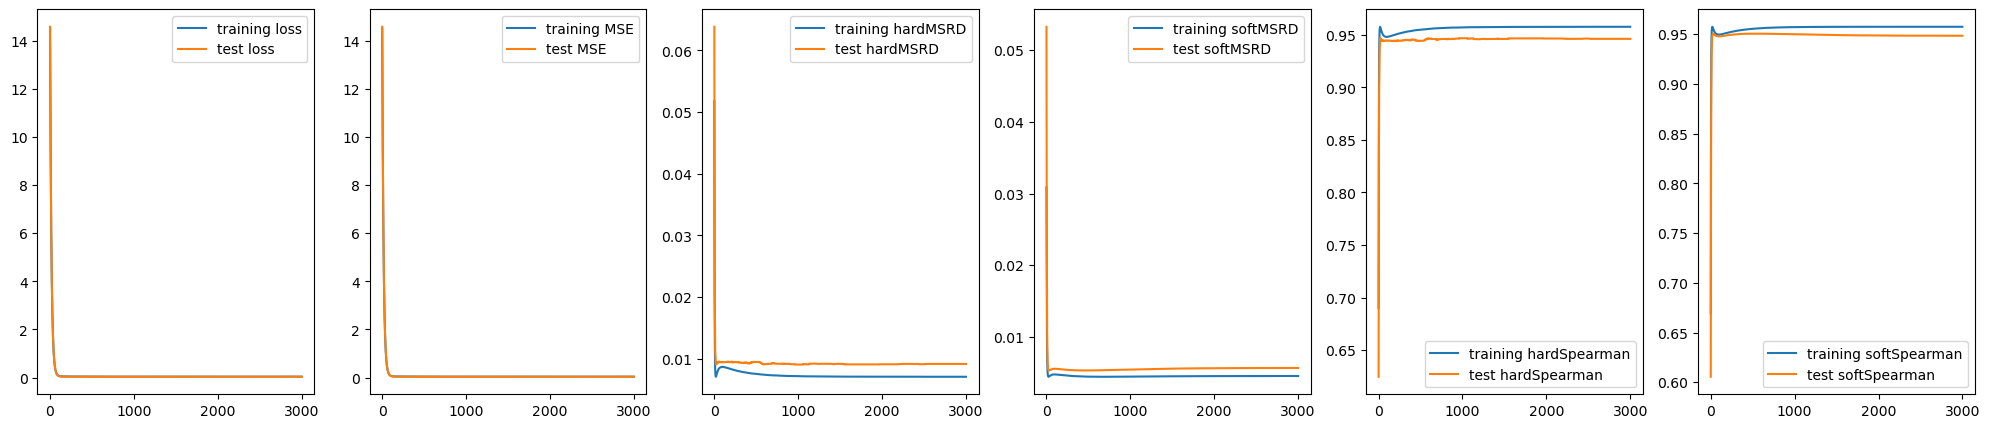

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=(stats.shape[1] // 2), figsize=(25, 5))
for i, ax in enumerate(axs):
    stats.iloc[:, 2*i:2*i+2].plot(ax=ax)

Model parameters evolution:

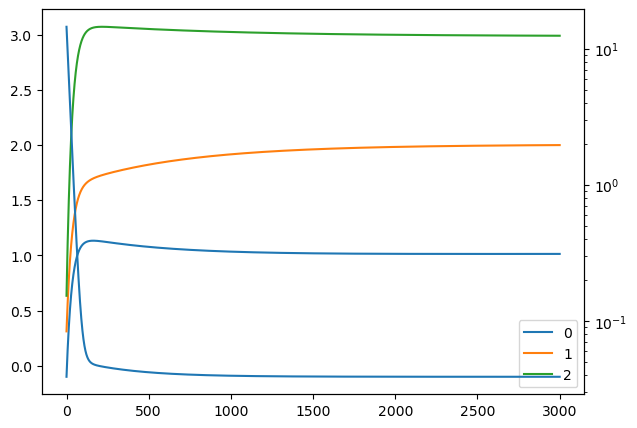

In [9]:
# fig, axs = plt.subplots()
ax1 = stats_params.plot(figsize=(7, 5))
ax2 = ax1.twinx()
ax2.plot(stats["training loss"])
ax2.set_yscale('log')

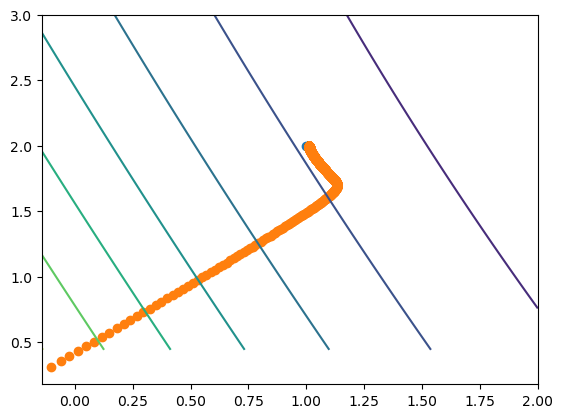

In [10]:
nx = 100
ny = 100

w = torch.linspace(-0.1420, 2, nx)
b = torch.linspace(0.44, 3, ny)
l = torch.zeros(nx, ny)

for i, w_ in enumerate(w):
    for j, b_ in enumerate(b):
        l[i, j] = ((y_train - w_ * X_train - b_)**2).sum()

fig, axs = plt.subplots()

axs.contour(w, b, l.numpy())
axs.scatter(1, 2)
axs.scatter(stats_params.iloc[:, 0], stats_params.iloc[:, 1])

Metrics vs params:

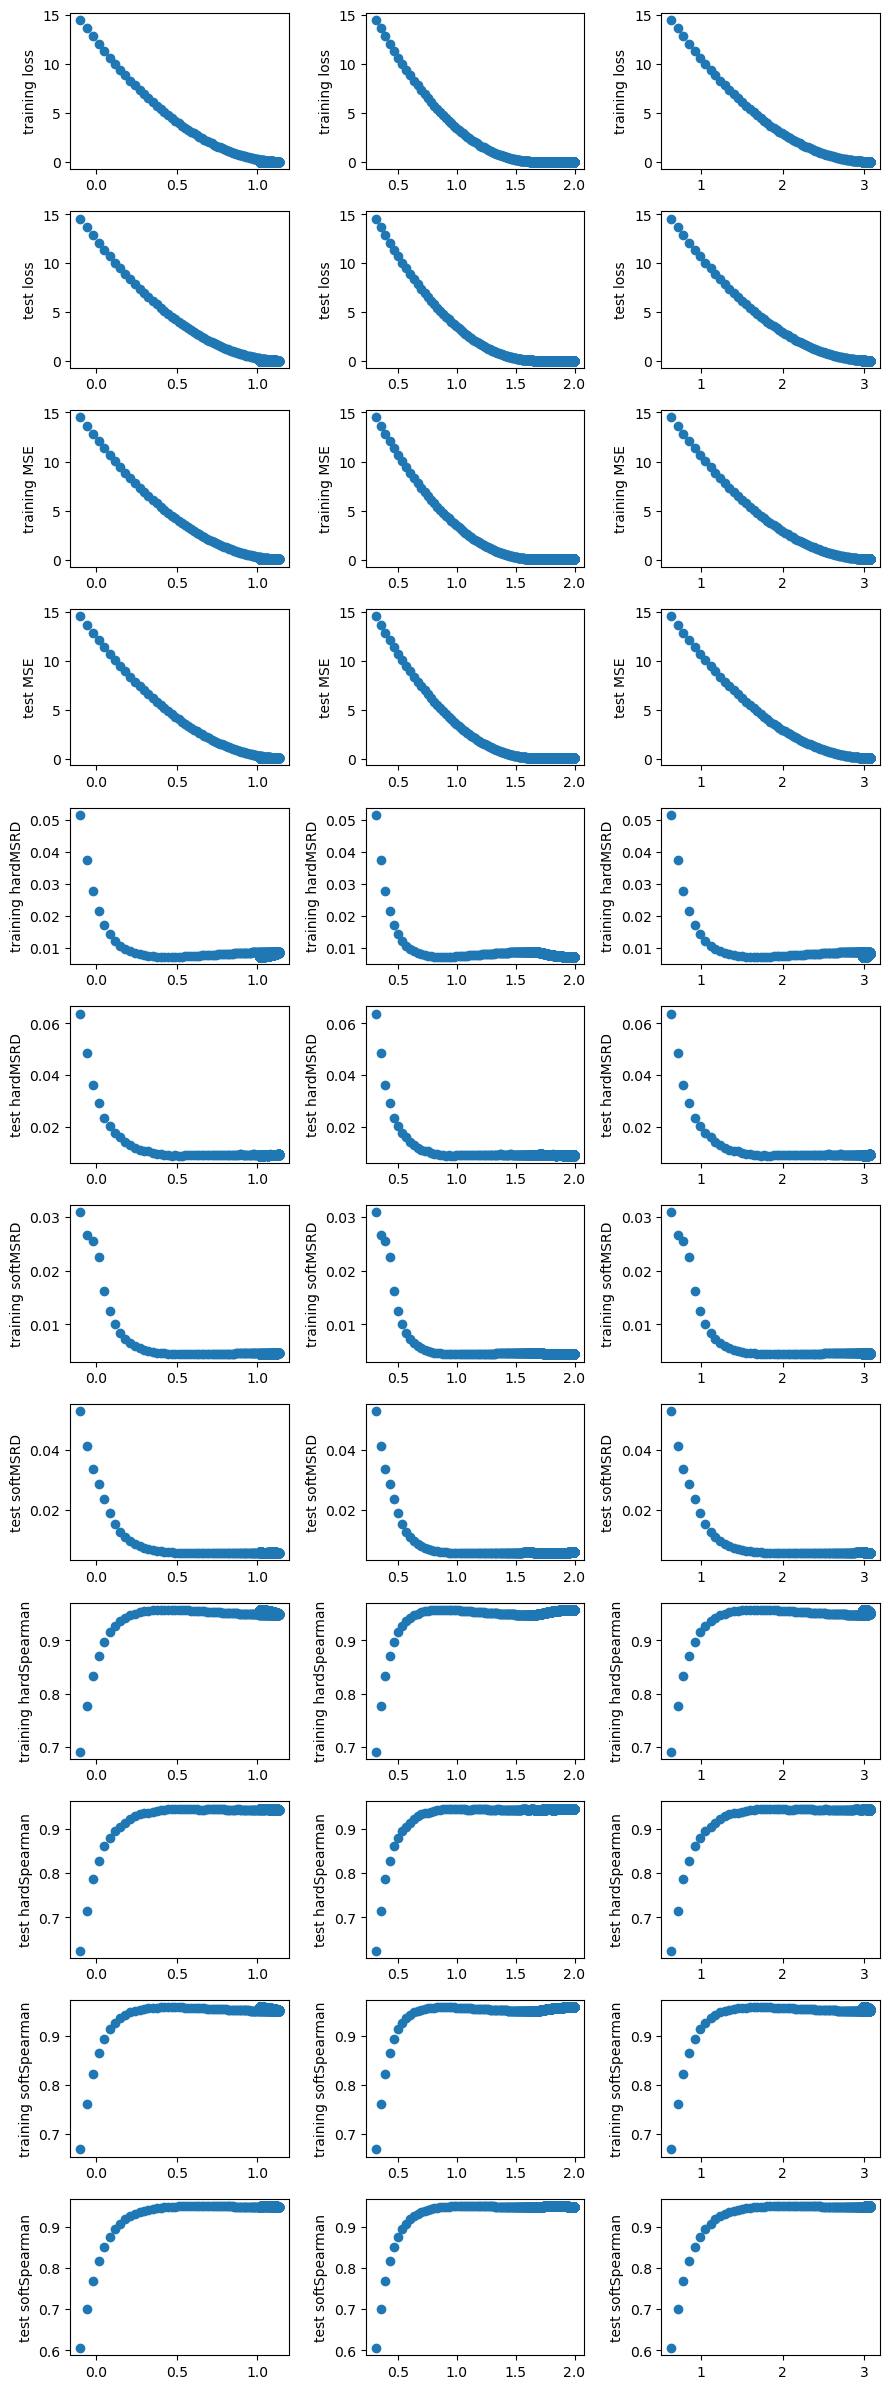

In [11]:
fig, axs = plt.subplots(nrows=stats.shape[1], ncols=stats_params.shape[1], sharex=False, figsize=(stats_params.shape[1]*3, stats.shape[1]*2))
for i in range(stats.shape[1]):
    for j in range(stats_params.shape[1]):
        axs[i, j].scatter(stats_params.iloc[:, j], stats.iloc[:, i])
        # axs[i, j].set_xlabel(j)
        axs[i, j].set_ylabel(stats.columns[i])
plt.tight_layout()
plt.show()

Soft-hard rank correlation:

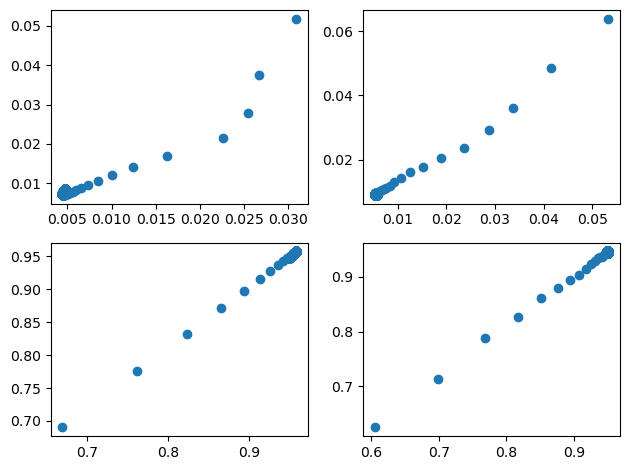

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2)

axs[0, 0].scatter(stats["training softMSRD"], stats["training hardMSRD"])
axs[0, 1].scatter(stats["test softMSRD"], stats["test hardMSRD"])

axs[1, 0].scatter(stats["training softSpearman"], stats["training hardSpearman"])
axs[1, 1].scatter(stats["test softSpearman"], stats["test hardSpearman"])

plt.tight_layout()
plt.show()

Spearman corr by eyes:

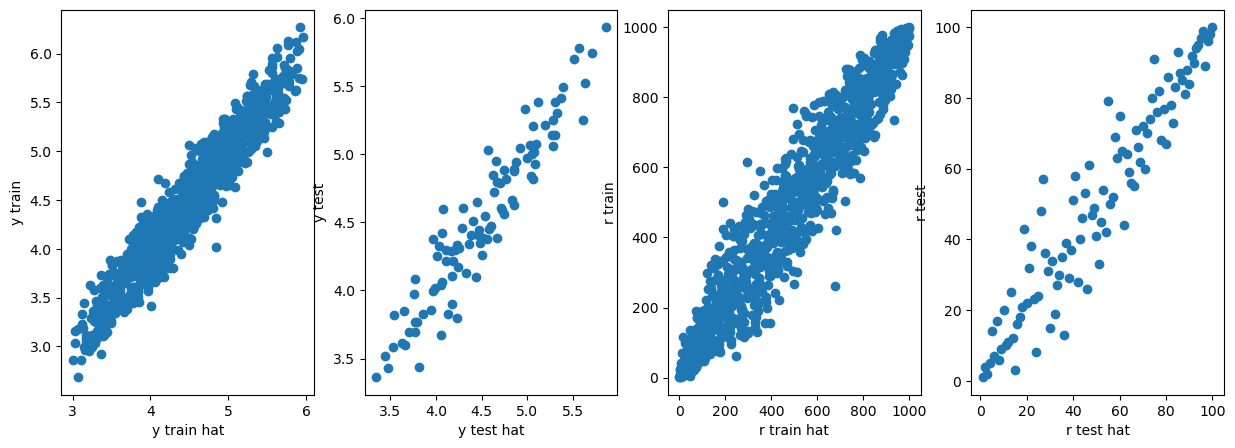

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

axs[0].scatter(model(X_train).detach().numpy(), y_train.numpy())
axs[0].set_xlabel("y train hat")
axs[0].set_ylabel("y train")

axs[1].scatter(model(X_test).detach().numpy(), y_test.numpy())
axs[1].set_xlabel("y test hat")
axs[1].set_ylabel("y test")

axs[2].scatter(rank(model(X_train)).detach().numpy(), rank(y_train).numpy())
axs[2].set_xlabel("r train hat")
axs[2].set_ylabel("r train")

axs[3].scatter(rank(model(X_test)).detach().numpy(), rank(y_test).numpy())
axs[3].set_xlabel("r test hat")
axs[3].set_ylabel("r test")

plt.show()

## Objective: MSRD, eval: exact MSRD

In [7]:
n_features = 1
n_samples = 1000
noise = 0.0

model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples, noise)

model, stats, stats_params = \
    train(
        X_train,
        y_train,
        X_test,
        y_test,
        n_features,
        n_steps=3000,
        lr=6e-1,
        weight_decay=0.0,
        loss_fn=loss_msrd,
        eval_fns=eval_fns
        )

Initial model params:
weight:	Parameter containing:
tensor([[-0.1420]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4401], requires_grad=True)

Final model params:
weight:	Parameter containing:
tensor([[0.5733]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4401], requires_grad=True)


Learning curves:

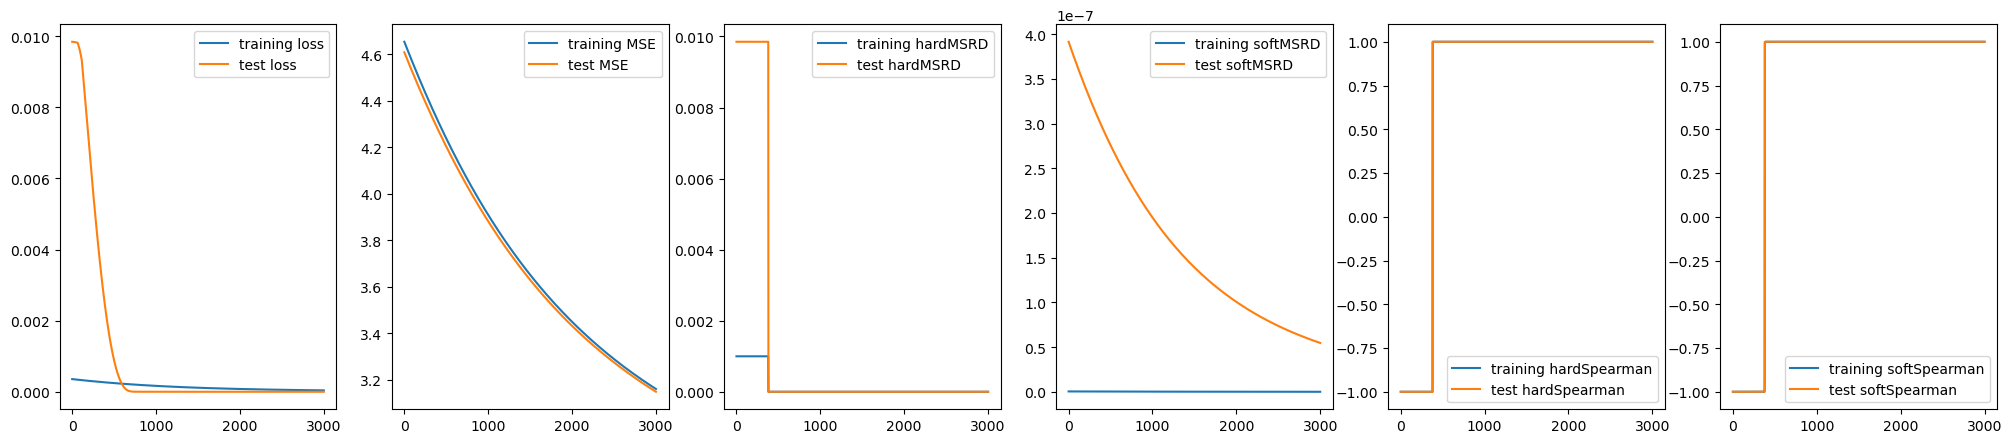

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=(stats.shape[1] // 2), figsize=(25, 5))
for i, ax in enumerate(axs):
    stats.iloc[:, 2*i:2*i+2].plot(ax=ax)

Model parameters evolution:

<Axes: >

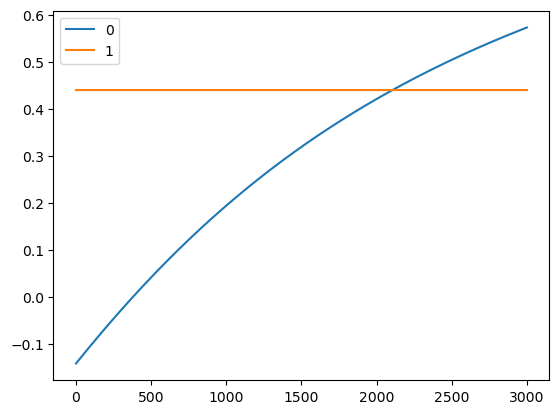

In [9]:
stats_params.plot()

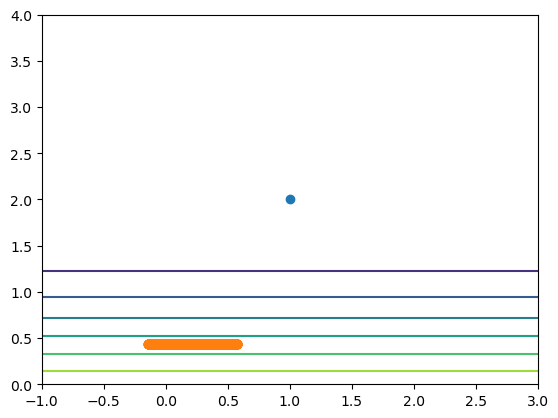

In [10]:
nx = 100
ny = 100

w = torch.linspace(-1, 3, nx)
b = torch.linspace(0, 4, ny)
l = torch.zeros(nx, ny)

for i, w_ in enumerate(w):
    for j, b_ in enumerate(b):
        l[i, j] = loss_msrd(y_train, w_ * X_train - b_).item()

fig, axs = plt.subplots()

axs.contour(w, b, l.numpy())
axs.scatter(1, 2)
axs.scatter(stats_params.iloc[:, 0], stats_params.iloc[:, 1])

Metrics vs params:

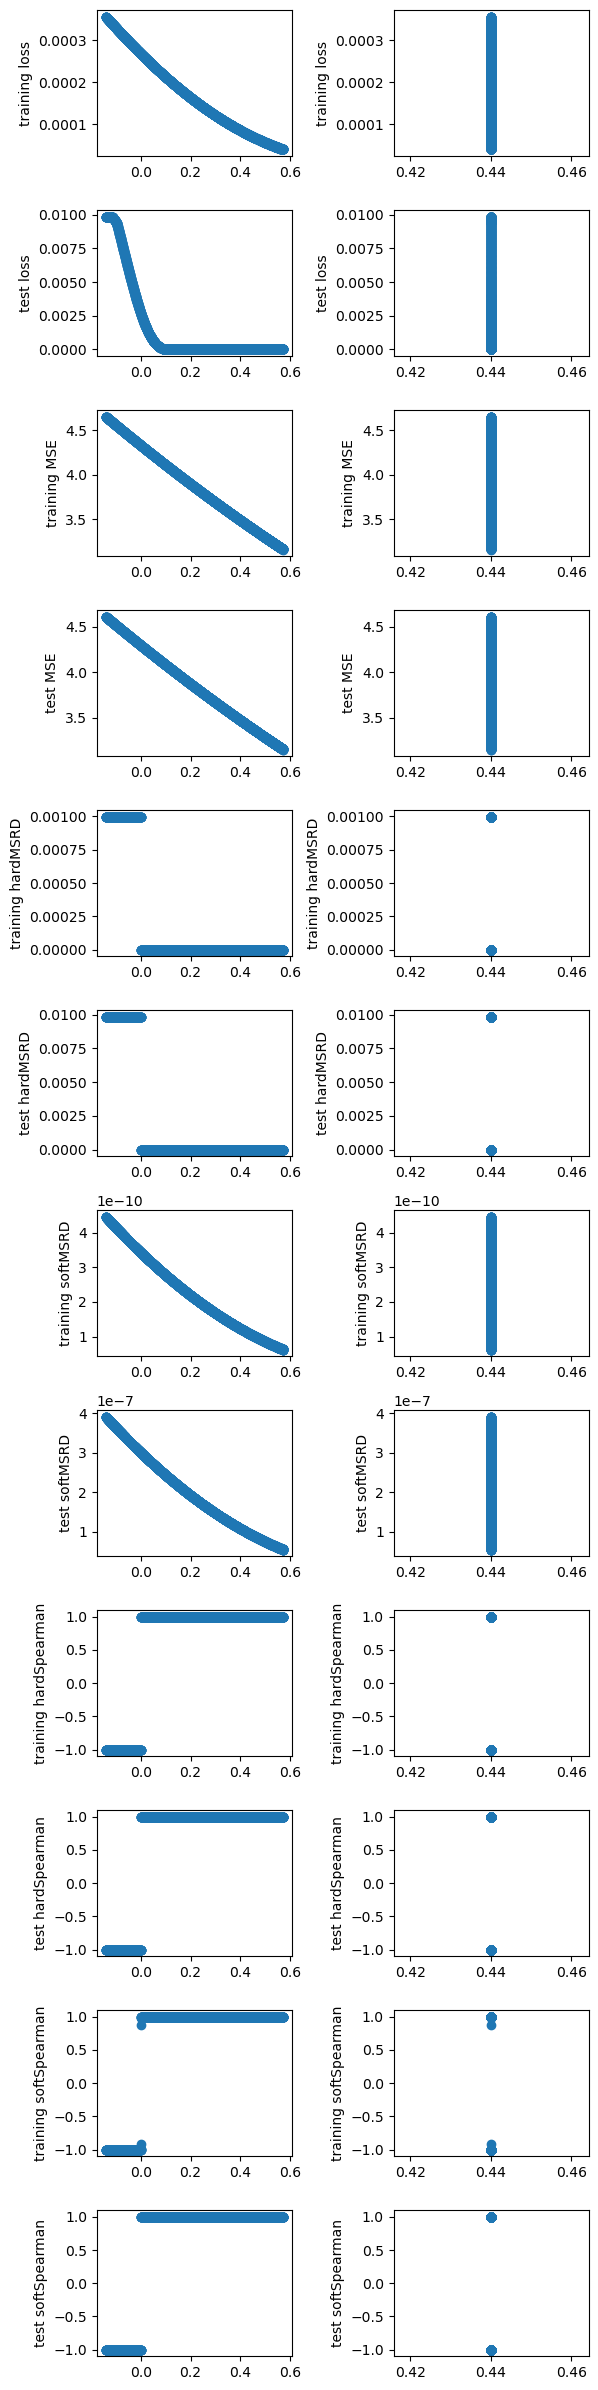

In [11]:
fig, axs = plt.subplots(nrows=stats.shape[1], ncols=stats_params.shape[1], sharex=False, figsize=(stats_params.shape[1]*3, stats.shape[1]*2))
for i in range(stats.shape[1]):
    for j in range(stats_params.shape[1]):
        axs[i, j].scatter(stats_params.iloc[:, j], stats.iloc[:, i])
        # axs[i, j].set_xlabel(j)
        axs[i, j].set_ylabel(stats.columns[i])
plt.tight_layout()
plt.show()

Soft-hard rank correlation:

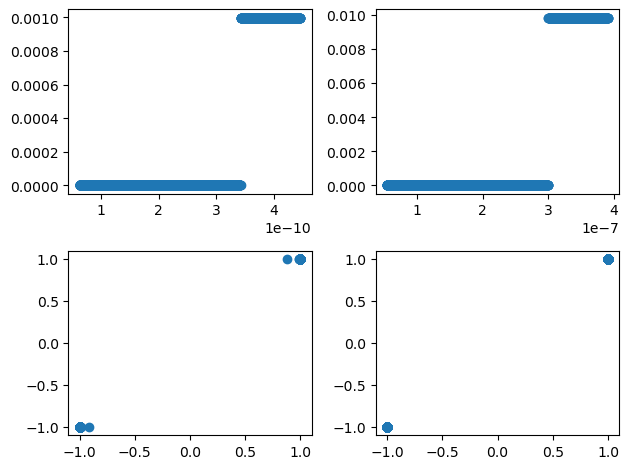

In [12]:
fig, axs = plt.subplots(nrows=2, ncols=2)

axs[0, 0].scatter(stats["training softMSRD"], stats["training hardMSRD"])
axs[0, 1].scatter(stats["test softMSRD"], stats["test hardMSRD"])

axs[1, 0].scatter(stats["training softSpearman"], stats["training hardSpearman"])
axs[1, 1].scatter(stats["test softSpearman"], stats["test hardSpearman"])

plt.tight_layout()
plt.show()

Spearman corr by eyes:

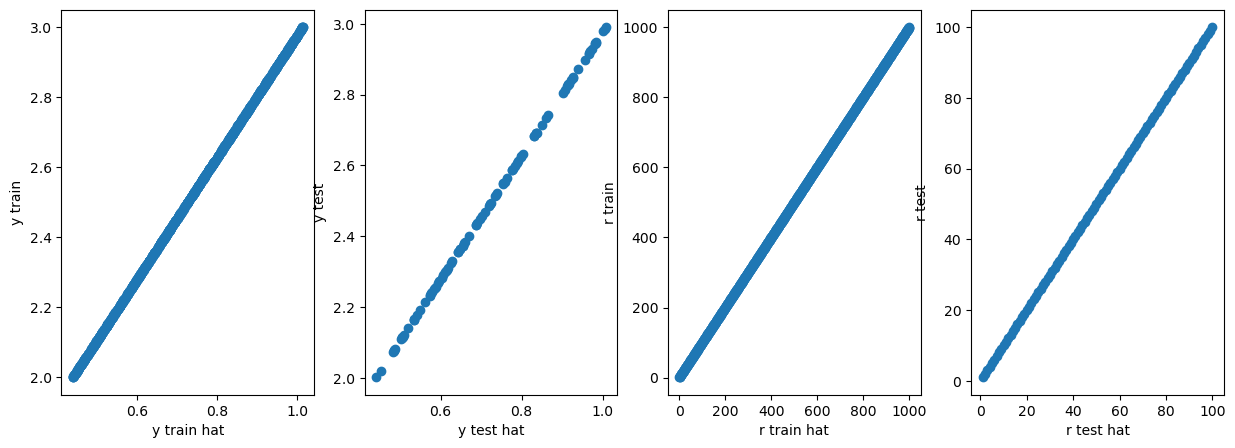

In [13]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

axs[0].scatter(model(X_train).detach().numpy(), y_train.numpy())
axs[0].set_xlabel("y train hat")
axs[0].set_ylabel("y train")

axs[1].scatter(model(X_test).detach().numpy(), y_test.numpy())
axs[1].set_xlabel("y test hat")
axs[1].set_ylabel("y test")

axs[2].scatter(rank(model(X_train)).detach().numpy(), rank(y_train).numpy())
axs[2].set_xlabel("r train hat")
axs[2].set_ylabel("r train")

axs[3].scatter(rank(model(X_test)).detach().numpy(), rank(y_test).numpy())
axs[3].set_xlabel("r test hat")
axs[3].set_ylabel("r test")

plt.show()

## Objective: Spearman

In [87]:
n_features = 1
n_samples = 3000
noise = 0.0

model_true, X_train, y_train, X_test, y_test = generate_data(n_features, n_samples, noise)

model, stats, stats_params = \
    train(
        X_train,
        y_train,
        X_test,
        y_test,
        n_features,
        n_steps=1000,
        lr=2e+3,
        weight_decay=0.0,
        loss_fn=loss_spearman,
        eval_fns=eval_fns
        )

Initial model params:
weight:	Parameter containing:
tensor([[-0.1420]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4401], requires_grad=True)

Final model params:
weight:	Parameter containing:
tensor([[0.1610]], requires_grad=True)
bias:	Parameter containing:
tensor([0.4402], requires_grad=True)


Learning curves:

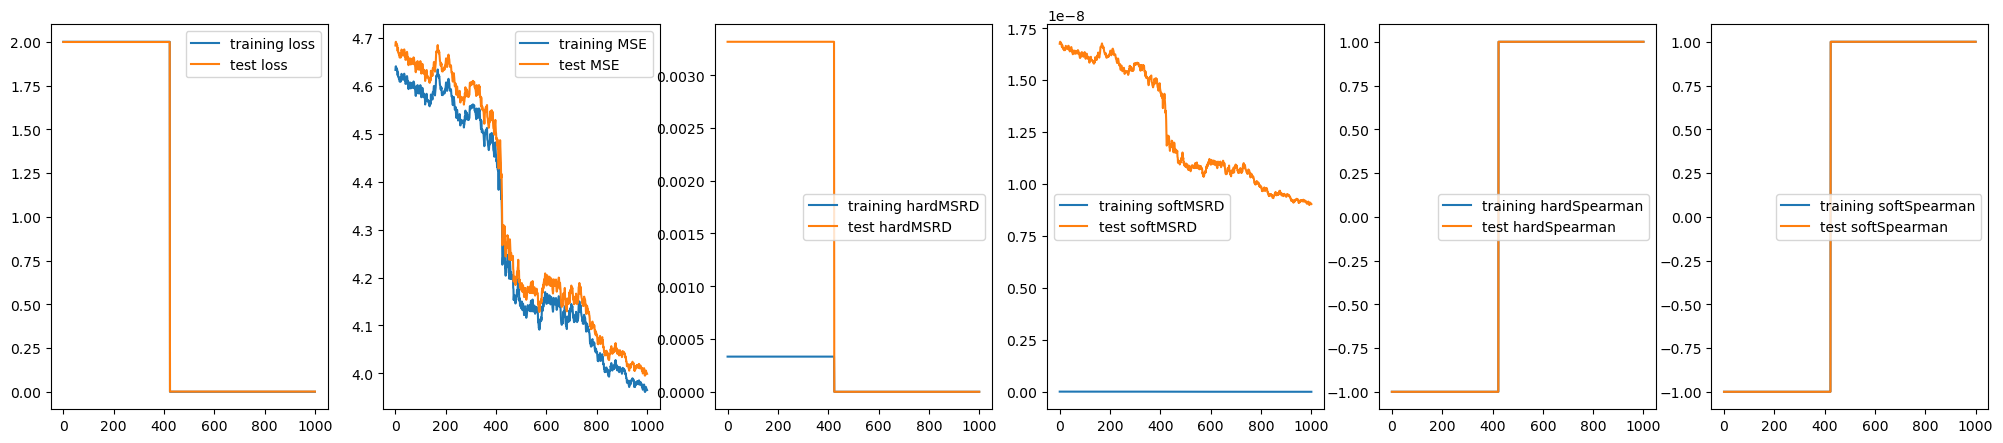

In [88]:
fig, axs = plt.subplots(nrows=1, ncols=(stats.shape[1] // 2), figsize=(25, 5))
for i, ax in enumerate(axs):
    stats.iloc[:, 2*i:2*i+2].plot(ax=ax)

Model parameters evolution:

<Axes: >

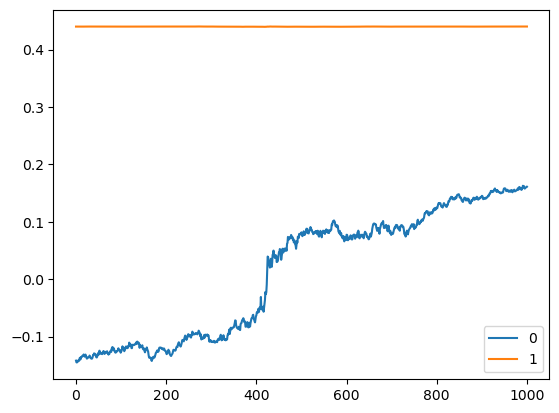

In [89]:
stats_params.plot()

Metrics vs params:

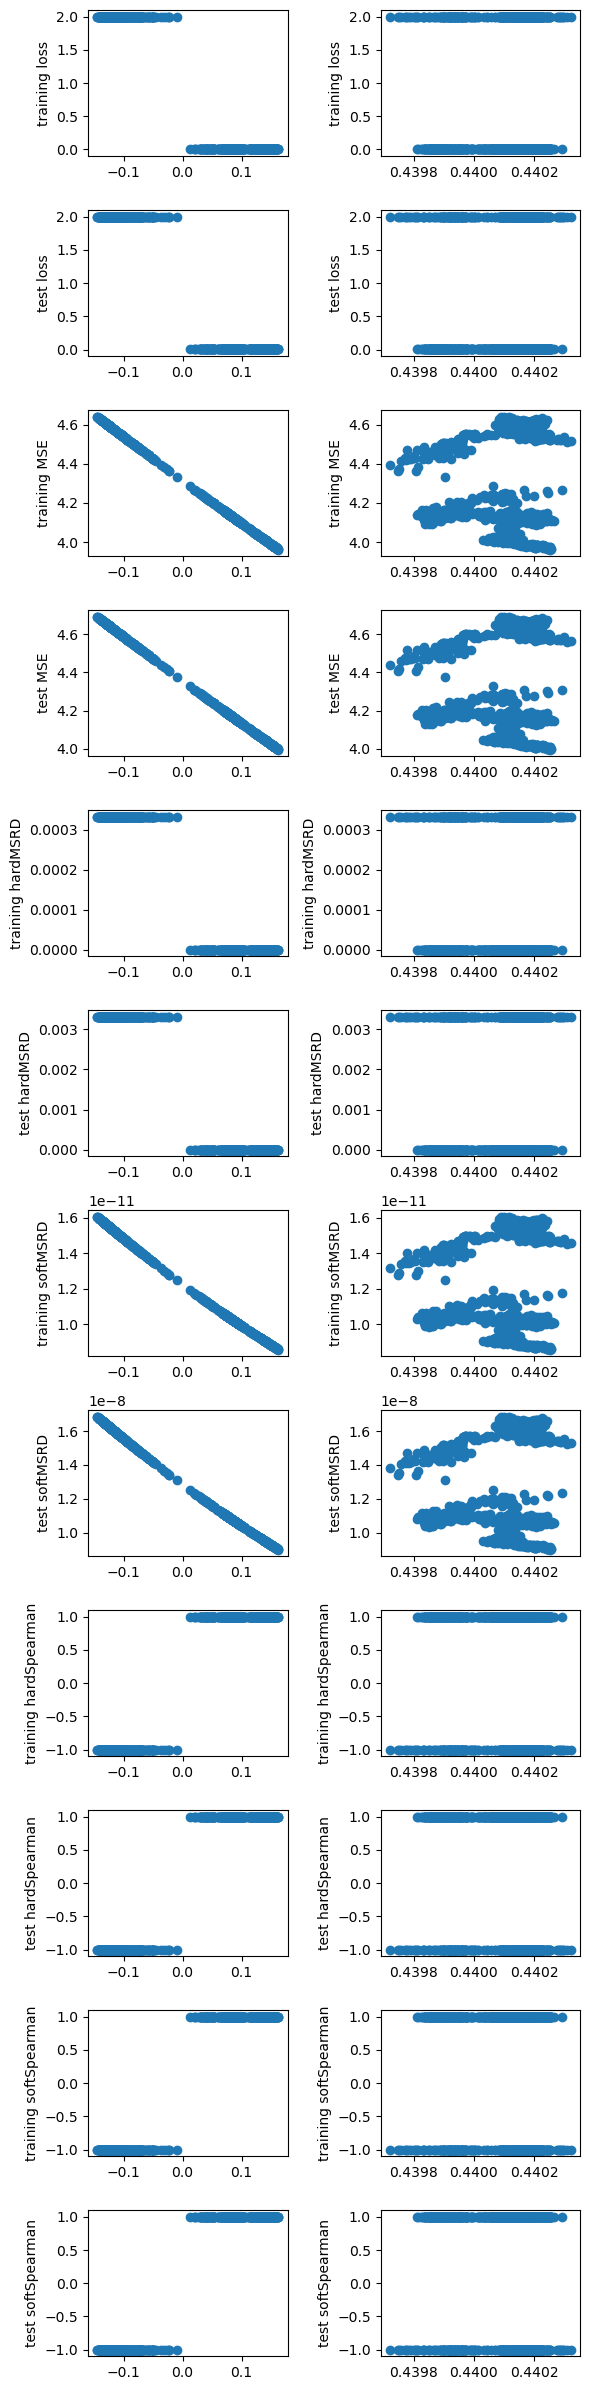

In [90]:
fig, axs = plt.subplots(nrows=stats.shape[1], ncols=stats_params.shape[1], sharex=False, figsize=(stats_params.shape[1]*3, stats.shape[1]*2))
for i in range(stats.shape[1]):
    for j in range(stats_params.shape[1]):
        axs[i, j].scatter(stats_params.iloc[:, j], stats.iloc[:, i])
        # axs[i, j].set_xlabel(j)
        axs[i, j].set_ylabel(stats.columns[i])
plt.tight_layout()
plt.show()

Soft-hard rank correlation:

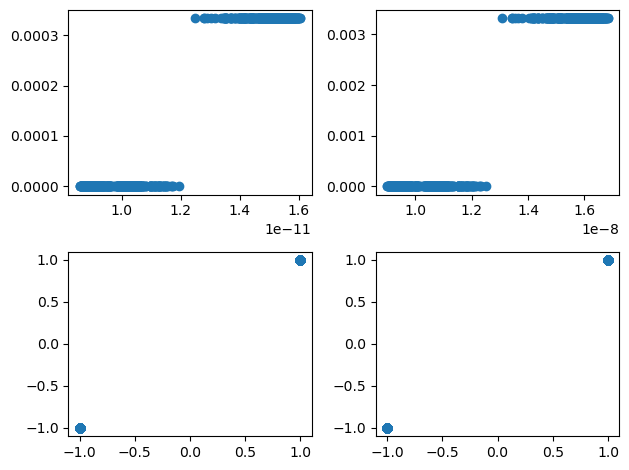

In [91]:
fig, axs = plt.subplots(nrows=2, ncols=2)

axs[0, 0].scatter(stats["training softMSRD"], stats["training hardMSRD"])
axs[0, 1].scatter(stats["test softMSRD"], stats["test hardMSRD"])

axs[1, 0].scatter(stats["training softSpearman"], stats["training hardSpearman"])
axs[1, 1].scatter(stats["test softSpearman"], stats["test hardSpearman"])

plt.tight_layout()
plt.show()

Spearman corr by eyes:

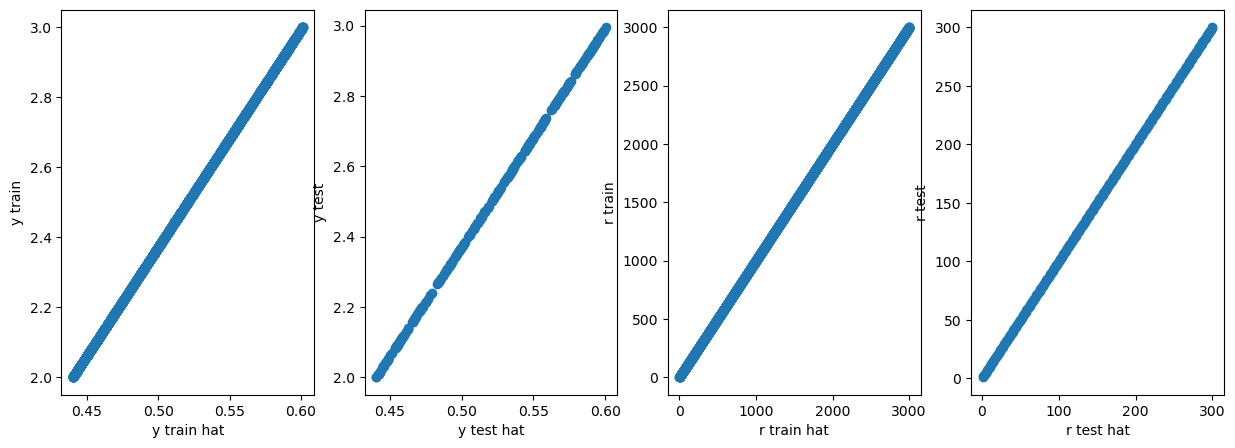

In [92]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

axs[0].scatter(model(X_train).detach().numpy(), y_train.numpy())
axs[0].set_xlabel("y train hat")
axs[0].set_ylabel("y train")

axs[1].scatter(model(X_test).detach().numpy(), y_test.numpy())
axs[1].set_xlabel("y test hat")
axs[1].set_ylabel("y test")

axs[2].scatter(rank(model(X_train)).detach().numpy(), rank(y_train).numpy())
axs[2].set_xlabel("r train hat")
axs[2].set_ylabel("r train")

axs[3].scatter(rank(model(X_test)).detach().numpy(), rank(y_test).numpy())
axs[3].set_xlabel("r test hat")
axs[3].set_ylabel("r test")

plt.show()